In [1]:
!pip install PyMuPDF

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 40.4 MB/s eta 0:00:00


In [3]:
import fitz

pdffile = "/content/Padilla - Nobleza virtuosa_testExtract.pdf"
doc = fitz.open(pdffile)
for i in range(0,16):
  page = doc.load_page(i)  # number of page
  pix = page.get_pixmap()
  output = f"/content/images/{i+1}.png"
  pix.save(output)

doc.close()

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# TR OCR

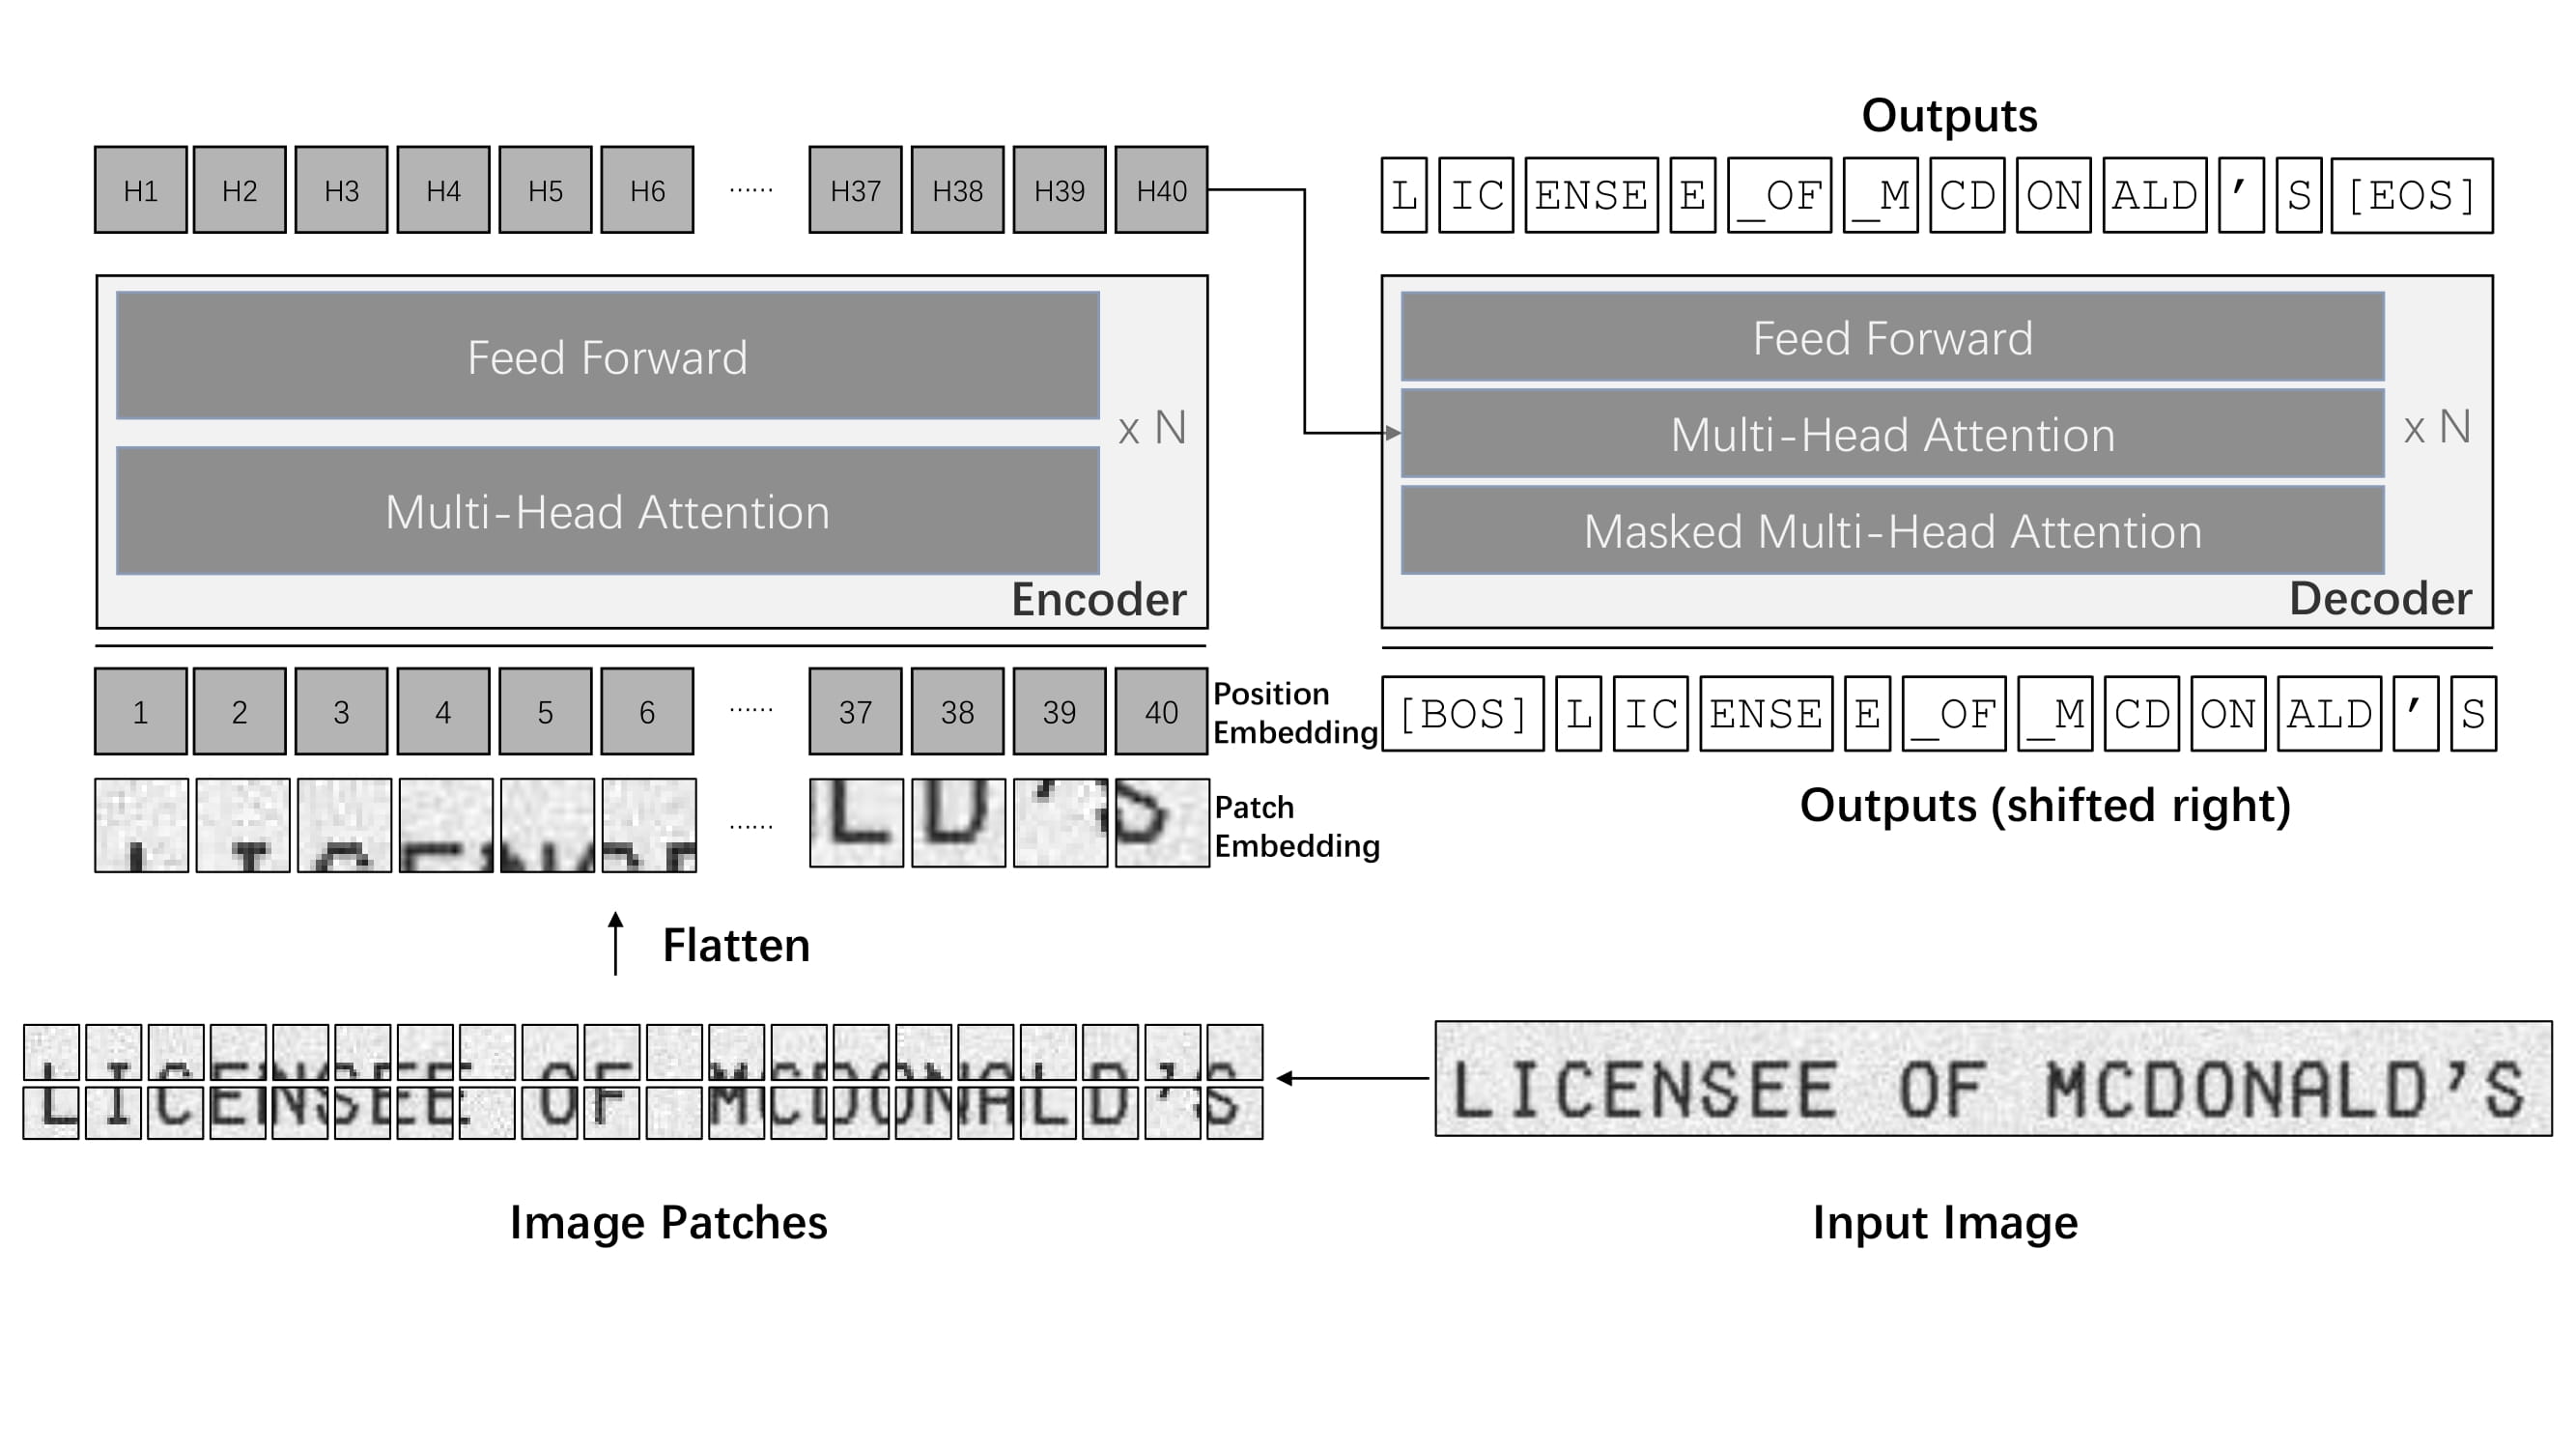

In [4]:
import transformers
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, AutoTokenizer, AutoModelForTokenClassification
from PIL import Image
import torch

def ocr_image(image):
    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load processor and model
    processor = TrOCRProcessor.from_pretrained('qantev/trocr-large-spanish')
    model = VisionEncoderDecoderModel.from_pretrained('qantev/trocr-large-spanish').to(device)

    # Preprocess image if it's not in 'RGB' mode
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Move input image to GPU
    image_tensor = processor(images=image, return_tensors="pt").pixel_values.to(device)

    # Perform inference
    with torch.no_grad():
        generated_ids = model.generate(image_tensor)

    # Move generated_ids back to CPU for decoding
    generated_ids = generated_ids.cpu()

    # Decode generated text
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return generated_text


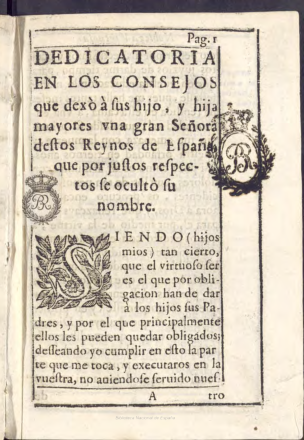

In [5]:
import requests
from IPython.display import display
from PIL import Image

def show_image(path):
  img = Image.open(path).convert("RGB")
  display(img)
  return img

image1 = show_image('/content/images/1.png')

In [6]:
import cv2
import numpy as np
from PIL import Image

def preprocess_image(image):
    # Convertto grayscale
    gray_image = image.convert('L')

    # Convert to numpy array
    np_image = np.array(gray_image)

    # Apply Gaussian blur to reduce noise
    # blurred_image = cv2.GaussianBlur(np_image, (5, 5), 0)

    # Thresholding to enhance text
    _, thresholded_image = cv2.threshold(np_image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    kernel = np.array([[0, -1, 0],
                      [-1, 5, -1],
                      [0, -1, 0]])
    sharpened = cv2.filter2D(thresholded_image, -1, kernel)
    # Convert back to PIL image
    processed_image = Image.fromarray(np.uint8(sharpened))

    return processed_image


In [ ]:
img1 = image1.crop((5, 290, image1.size[0]-75, 310))
img1 = preprocess_image(img1)
display(img1)

In [7]:
import os
from PIL import Image

def generate_ocr_text(image_path,window_size=20):
    image = Image.open(image_path)
    if image.size[0] < 310:
      page = 1
      left = [5]
      right = [image.size[0]-70]
    elif image.size[0] > 310 and image.size[0] < 615:
      page = 2
      window_size = window_size - 9
      left = [50,300]
      right = [image.size[0]-305,image.size[0]]

    ocr_text = []
    for pages_c in range(page):
      top = 40
      if page == 1:
        bottom = 80
      elif page==2:
        bottom = 60
      iter = 1
      while bottom <= 410:
        if iter == 9 and page==1:
          top = bottom - 20
          bottom = bottom
          window_size = window_size - 10

        img = image.crop((left[pages_c], top, right[pages_c], bottom))
        # img = preprocess_image(img)
        # display(img)
        generated_text = ocr_image(img)
        ocr_text.append(generated_text)
        # print(generated_text)
        top = top + window_size
        bottom = bottom + window_size
        iter = iter + 1
    return ocr_text


## Generate OCR Text

In [ ]:
ocr_text = generate_ocr_text('/content/images/10.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
directory = '/content/images'
for filename in os.listdir(directory):
  if filename.endswith('.png'):
    image_path = os.path.join(directory, filename)
    print(f"Working on Image : {image_path}")
    ocr_text = generate_ocr_text(image_path)

    with open(f'{filename}.txt','w',encoding="utf-8") as f:
      for item in ocr_text:
          f.write(item + "\n")

      files.download(f'{filename}.txt')


## Cleaning of OCR Output and Evaluation

In [16]:
import re

def clean_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()

    # Remove unwanted characters such as numbers and special symbols
    cleaned_text = re.sub(r'[^a-zA-Z\s.,]', '', text)

    # Remove extra whitespace and normalize spaces
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text.strip())

    return cleaned_text

In [ ]:
generated_text = clean_text('/content/1.txt')

In [ ]:
with open('/content/1_actual.txt', 'r', encoding='utf-8') as file:
    text = file.read()

In [8]:
!pip install python-Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 21.9 MB/s eta 0:00:00


In [10]:
!pip install editdistance

In [9]:
import Levenshtein

def evaluate_text_similarity(generated_text, actual_text):
    distance = Levenshtein.distance(generated_text, actual_text)
    similarity_ratio = Levenshtein.ratio(generated_text, actual_text)

    print("Levenshtein Distance:", distance)
    print("Similarity Ratio:", similarity_ratio)

In [12]:
import editdistance
def evaluate_ocr(reference_text, hypothesis_text):
    cer = editdistance.eval(reference_text, hypothesis_text) / max(len(reference_text), len(hypothesis_text))
    wer = editdistance.eval(reference_text.split(), hypothesis_text.split()) / len(reference_text.split())
    print("Character Error Rate:", cer)
    print("Word Error Rate:", wer)

In [13]:
def evaluate(generated_text,text):
  evaluate_text_similarity(generated_text,text)
  evaluate_ocr(generated_text,text)

In [ ]:
pdfno=['1','2','3','7','8','10']

for pdf in pdfno:
  generated_text = clean_text(f'/content/{pdf}.txt')
  with open(f'/content/{pdf}_actual.txt', 'r', encoding='utf-8') as file:
      text = file.read()
  print(f"{pdf} pdf Results")
  evaluate(generated_text,text)

In [ ]:
print("PDF 14:")
generated_text = clean_text('/content/14.txt')
print(generated_text)

In [ ]:
print("PDF 15:")
generated_text = clean_text('/content/15.txt')
print(generated_text)

In [ ]:
print("PDF 16:")
generated_text = clean_text('/content/16.txt')
print(generated_text)